# Data Ingestion

## Copy CSV files to S3

In [ ]:
# Assume all the pre-requisites were set up 
%store -r setup_instance_check_passed
%store -r setup_dependencies_passed
%store -r setup_s3_bucket_passed
%store -r setup_iam_roles_passed


In [ ]:
# Load Libraries
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [ ]:
# Public Data
!aws s3 ls s3://ads508team5/

# Copy Datasets from :
# Source of data
s3_public_path_tweeter = "s3://ads508team5/tweeter"
s3_public_path_nyt = "s3://ads508team5/nyt"

# Destination Data:

s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)

# Copy datasets
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_donaldtrump.csv"
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_joebiden.csv"
!aws s3 cp --recursive $s3_public_path_nyt/ $s3_private_path_nyt/ --exclude "*" --include "nyt-comments-2020.csv"


## Create Database, Tables and Parquets
### Database

In [ ]:
# Setup and check pre-requisites to create Database
ingest_create_athena_db_passed = False

#!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [ ]:
# Create Database
database_name = "dbpoliticpulsecomment"

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

# Verify DB successfully created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)


In [ ]:
# End of Create Database
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Tables

In [ ]:
# Create Tweeter Tables
table_name_csv = "tweeter"
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
  created_at TIMESTAMP,
  tweet_id FLOAT,
  tweet VARCHAR(250),
  likes INT,
  retweet_count INT,
  source VARCHAR(45),
  user_id INT,
  user_name VARCHAR(250),
  user_screen_name VARCHAR(45),
  user_description VARCHAR(250),
  user_join_date TIMESTAMP,
  user_followers_count INT,
  user_location VARCHAR(45),
  lat FLOAT,
  long FLOAT,
  city VARCHAR(45),
  country VARCHAR(45),
  continent VARCHAR(45),
  state VARCHAR(45),
  state_code VARCHAR(45),
  collected_at VARCHAR(45)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_tweeter
)

pd.read_sql(statement, conn)


In [ ]:
# testing hashtag_donaldtrump.csv tweet
tweet = "You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D"
# testing hashtag_joebiden.csv tweet
tweet = "@chrislongview Watching and setting dvr. Let’s give him bonus ratings!! #JoeBiden"


statement = """SELECT * FROM {}.{}
    WHERE tweet = '{}' LIMIT 100""".format(
    database_name, table_name_csv, tweet
)

df = pd.read_sql(statement, conn)
df.head(5)


In [ ]:
# Create NYT comment Table
table_name_csv = "nyt_comment"
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)


statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
  commentID INT,
  status VARCHAR(20),
  commentSequence INT,
  userID INT,
  userDisplayName VARCHAR(45),
  userLocation VARCHAR(45),
  userTitle VARCHAR(10),
  commentBody VARCHAR(500),
  createDate TIMESTAMP,
  updateDate TIMESTAMP,
  approveDate TIMESTAMP,
  recommendation INT,
  replyCount INT,
  editorsSelection VARCHAR(20),
  parentID INT,
  parentUserDisplayName VARCHAR(45),
  depth INT,
  commentType VARCHAR(20),
  trusted VARCHAR(20),
  recommendedFlag VARCHAR(20),
  permID INT,
  isAnonymous VARCHAR(20),
  articleID VARCHAR(150)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_nyt
)

pd.read_sql(statement, conn)


In [ ]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

In [ ]:
commentBody = "@Philip Brown Agree 110%."

statement = """SELECT * FROM {}.{}
    WHERE commentBody = '{}' LIMIT 100""".format(
    database_name, table_name_csv, commentBody
)

df = pd.read_sql(statement, conn)
df.head(5)


### Parquets

In [ ]:
table_comment = "comment"
table_tweeter = "tweeter"
table_nyt_comment = "nyt_comment"

# SQL Statement combine tweeter and NYT comment in the preparation to create parquet
statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT 
    tweet_id AS comment_id,
    tweet AS comment_body,
    user_id AS user_id,
    user_name AS user_name,
    user_location AS user_location,
    created_at AS create_date,
    retweet_count AS reply_retweet,
    likes AS recommendation_like,
    'tweet' as source,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE 
        WHEN 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN              
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM
    {}.{}
WHERE
    LENGTH(tweet) > 3
UNION
SELECT 
    commentid AS comment_id,
    commentbody AS comment_body,
    userID AS user_id,
    userDisplayName AS user_name,
    userLocation AS user_location,
    createDate AS create_date,
    replyCount AS reply_retweet,
    recommendation AS recommendation_like,
    'nyt_comment' as source,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM 
    {}.{}
WHERE LENGTH(commentbody) > 3
)""".format(database_name, table_comment,database_name, table_tweeter,database_name, table_nyt_comment)

pd.read_sql(statement, conn)

In [ ]:
commentbody = "Joe Biden"
source = "nyt_comment"

statement = """SELECT * FROM {}.{}
    WHERE comment_body like '{}%' and source = '{}' LIMIT 100""".format(
    database_name, table_comment, commentbody, source
)

df = pd.read_sql(statement, conn)
df.head(5)


,comment_id,comment_body,user_id,user_name,user_location,create_date,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,108612056.0,Joe Biden should present the people he would p...,13762875,Joe c,MO,2020-08-13 12:03:49,3,9,nyt_comment,0,1,Biden
1,108083056.0,Joe Biden should return the contributions whic...,37435084,Common Ground,New York,2020-07-11 12:38:07,0,5,nyt_comment,0,1,Biden
2,108984560.0,Joe Biden’s son served in Iraq. That’s more th...,19850181,SR,Portland,2020-09-05 03:08:18,0,1,nyt_comment,0,2,Biden
3,108982920.0,Joe Biden vs. Donald Trump - a genuine America...,48911378,Rocco Gibraltar,Democratic America,2020-09-05 00:27:17,0,60,nyt_comment,2,2,None
4,108971000.0,Joe Biden could change the race by campaigning...,46464992,rene,harlem,2020-09-04 12:59:59,1,9,nyt_comment,2,1,Trump


In [ ]:
# Setup to create Parquet
ingest_create_athena_table_parquet_passed = False

# Set S3 path to Parquet data
s3_path_parquet = "s3://{}/ADS508_project/parquet".format(bucket)

table_parquet = "comment_parquet"

In [ ]:
# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['candidatepoll']) AS
SELECT comment_id,
         user_name,
         user_location,
         comment_body,
         reply_retweet,
         recommendation_like,
         source,
         trump_count,
         biden_count,
         candidatepoll
FROM {}.{}
where candidatepoll is not null""".format(
    database_name, table_parquet, s3_path_parquet, database_name, table_comment
)
pd.read_sql(statement, conn)


In [ ]:
#load the Parquet partitions
statement = "MSCK REPAIR TABLE {}.{}".format(database_name, table_parquet)

df = pd.read_sql(statement, conn)
df.head(5)

In [ ]:
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_parquet)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

In [ ]:
statement = "SHOW TABLES in {}".format(database_name)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

In [ ]:
candidatepoll = "Trump"

statement = """SELECT * FROM {}.{}
    Where candidatepoll = '{}' LIMIT 10""".format(
    database_name, table_parquet, candidatepoll
)
df_parquet = pd.read_sql(statement, conn)
df_parquet.head(5)

,comment_id,user_name,user_location,comment_body,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,1.322397e+18,25932078.0,Radio Host,"""&gt; #Trump has broken every law",0.0,NaN,tweet,1,0,Trump
1,1.322398e+18,MW,,American People love the USA &amp; it's freedo...,0.0,0.0,tweet,1,0,Trump
2,1.322398e+18,Mary,equality,@realDonaldTrump Always projecting #LiarInChie...,0.0,0.0,tweet,2,0,Trump
3,1.322398e+18,DUMP Trump #Resist,Los Angeles & Canada,#Trump doesn't even know what #RealMelania loo...,0.0,0.0,tweet,1,0,Trump
4,1.322398e+18,Mr.GreenEconomy 🌎🌍🌏🌊☀️,None,@catturd2 @ElevatedMonkey You realize that @Hi...,0.0,4.0,tweet,1,0,Trump


## Query Data

In [ ]:
# Setup and check pre-requisites to create Database

!pip install --disable-pip-version-check -q awswrangler
import awswrangler as wr

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [ ]:
t_filter = lambda x: x["candidatepoll"] == "Trump"
b_filter = lambda x: x["candidatepoll"] == "Biden"

In [ ]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=t_filter, dataset=True
)

df_parquet_results_trump = df_parquet_results.drop_duplicates(subset = ['comment_body'])

In [97]:
df_parquet_results_trump.shape

(926684, 4)

In [ ]:
df_parquet_results_trump.head(5)

,comment_body,source,user_location,candidatepoll
0,"""WIN = trump https://t.co/v4yRMK4rrX",tweet,<NA>,Trump
1,"""@realDonaldTrump EVRRYONE KNOWS. WELL ANYONE ...",tweet,<NA>,Trump
2,"""@BrettFavre @realDonaldTrump Principle’s are ...",tweet,<NA>,Trump
3,"""Anything Trump can do",tweet,2626.0,Trump
4,"""Trump is winning.",tweet,<NA>,Trump


In [ ]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

# Call all public discourse data from 
df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=b_filter, dataset=True
)


df_parquet_results_biden = df_parquet_results.drop_duplicates(subset = ['comment_body'])
df_parquet_results_biden.shape


(434926, 4)

In [ ]:
df_parquet_results_biden.head(5)

,comment_body,source,user_location,candidatepoll
0,#Cubanos por #Biden sacan las uñas para defend...,tweet,"""Miami",Biden
1,"""#Biden promete firmar una orden ejecutiva par...",tweet,<NA>,Biden
2,"""@Fxhedgers 3 Trillion Stimulus will be passed...",tweet,<NA>,Biden
3,America’s next president = Democratic af. #Kam...,tweet,2020-07-30 14:42:29,Biden
4,"""Here's the next thing Joe Biden says he will ...",tweet,<NA>,Biden


# Data Exploration

In [ ]:
# Checking for missing values from trump data
df_parquet_results_trump.info()

In [ ]:
# Check for missing values from  biden data
df_parquet_results_biden.info()

In [ ]:
# Data Distributions for Trump and Biden 
df_parquet_results_trump['source'].value_counts()


In [ ]:
# Data Distributions for Trump and Biden 
df_parquet_results_biden['source'].value_counts()

In [ ]:
# Filtering Data by Location 
df_parquet_results_trump['user_location'].value_counts()

                                                 64393
NYC                                              13502
California                                       11827
New York                                         11436
USA                                               8575
                                                 ...  
maxime7807                                           1
 basically that is the composition of the Rep        1
Not NY                                               1
 Louisiana                                           1
"sport nut                                           1
Name: user_location, Length: 94255, dtype: Int64

In [ ]:
# Top 30 locations of social media activity
df_parquet_results_trump['user_location'].value_counts().head(30)

                 64393
NYC              13502
California       11827
New York         11436
USA               8575
Chicago           6948
Los Angeles       6684
NY                6620
San Francisco     6229
Seattle           6036
Florida           5700
NJ                5522
Boston            5312
United States     4949
New York City     4227
Canada            4204
New Jersey        3986
Colorado          3781
Brooklyn          3735
Texas             3713
CA                3478
Philadelphia      3155
Massachusetts     2763
Oregon            2756
Virginia          2723
Atlanta           2689
San Diego         2525
NC                2393
Maryland          2391
Midwest           2297
Name: user_location, dtype: Int64

In [ ]:
df_parquet_results_biden['user_location'].value_counts()

                                                 49138
United States                                     3483
New York                                          2485
NYC                                               2395
USA                                               2281
                                                 ...  
2018-06-19 02:23:32                                  1
 Nordic countries                                    1
"Karur                                               1
 God bless ALL the American people 🇺🇸 I’m not        1
 MH Counselor. Exposing Crime & Corruption in        1
Name: user_location, Length: 73592, dtype: Int64

In [ ]:
# Top 30 locations of social media activity
df_parquet_results_biden['user_location'].value_counts().head(30)

# Create EDA Overview Data Visualization

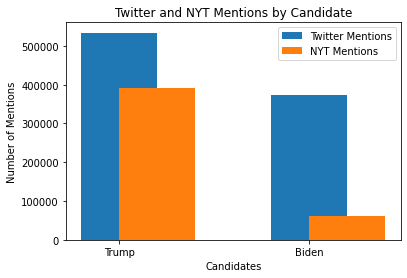

In [ ]:
# Data Sources for Each Candidate
# Code from ChatGPT

import matplotlib.pyplot as plt

candidate = ['Trump','Biden']
twitter_n = [df_parquet_results_trump['source'].value_counts()[0],df_parquet_results_biden['source'].value_counts()[0]]
nyt_n = [df_parquet_results_trump['source'].value_counts()[1],df_parquet_results_biden['source'].value_counts()[1]]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.1/520.1 kB 5.5 MB/s eta 0:00:00:00:01
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


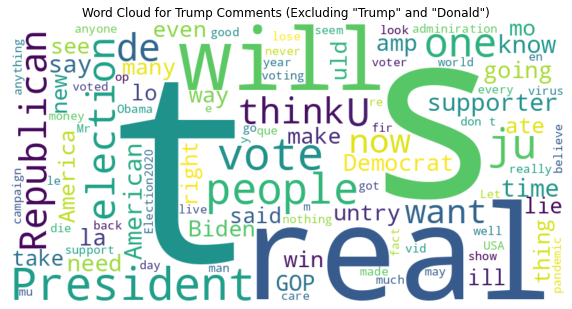

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Sample a subset of comments for generating the word cloud
sampled_trump_comments = df_parquet_results_trump['comment_body'].dropna().sample(n=10000, random_state=42)

# Concatenate sampled comments for Trump
trump_comments_text = ' '.join(sampled_trump_comments)

# Define words and patterns to exclude
words_to_exclude = ['trump', 'donald', 'donaldtrump', 'https', 'co', 'st'] 
patterns_to_exclude = [r'\btrump\b', r'\bdonald\b', r'\bdonaldtrump\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
trump_comments_text_cleaned = re.sub(exclude_patterns, '', trump_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Trump comments with a limit on the number of words
wordcloud_trump = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(trump_comments_text_cleaned)

# Plot the word cloud for Trump
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_trump, interpolation='bilinear')
plt.title('Word Cloud for Trump Comments (Excluding "Trump" and "Donald")')
plt.axis('off')
plt.show()

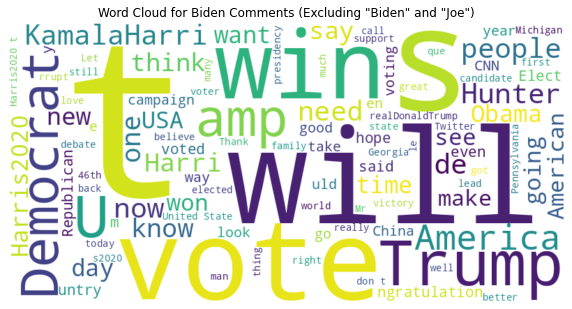

In [116]:
# Sample a subset of comments for Biden
sampled_biden_comments = df_parquet_results_biden['comment_body'].dropna().sample(n=40000, random_state=42)

# Concatenate sampled comments for Biden
biden_comments_text = ' '.join(sampled_biden_comments)

# Define words and patterns to exclude
words_to_exclude = ['biden', 'joe', 'joebiden', 'president', 'election', 'https', 'co','amp']  # Exclude common words and URLs
patterns_to_exclude = [r'\bbiden\b', r'\bjoe\b', r'\bjoebiden\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
biden_comments_text_cleaned = re.sub(exclude_patterns, '', biden_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Biden comments with a limit on the number of words
wordcloud_biden = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(biden_comments_text_cleaned)

# Plot the word cloud for Biden
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_biden, interpolation='bilinear')
plt.title('Word Cloud for Biden Comments (Excluding "Biden" and "Joe")')
plt.axis('off')
plt.show()

# Sentiment Labels Using Textblob

In [ ]:
# Code from ChatGPT
#!pip install textblob
from textblob import TextBlob

def analyze_tweet_sentiment(tweet_text):
    analysis = TextBlob(tweet_text)
    # Return sentiment polarity (ranging from -1 to 1)
    return analysis.sentiment.polarity


In [117]:
# Apply sentiment labels to Trump Data
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    df_tweets_trump = df_parquet_results_trump[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    df_tweets_trump['sentiment_score'] = df_tweets_trump['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_parquet_results_trump['sentiment'] = df_tweets_trump['sentiment_score']


/tmp/ipykernel_10174/2692217972.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_trump['sentiment_score'] = df_tweets_trump['comment_body'].apply(analyze_tweet_sentiment)


In [118]:
 # Apply Sentiment labels to Biden Data       
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    df_tweets_biden = df_parquet_results_biden[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    df_tweets_biden['sentiment_score'] = df_tweets_biden['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']


/tmp/ipykernel_10174/1914027081.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_biden['sentiment_score'] = df_tweets_biden['comment_body'].apply(analyze_tweet_sentiment)
/tmp/ipykernel_10174/1914027081.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']


## Trump

In [119]:
# Examine Trump Sentiment distribution
df_parquet_results_trump['sentiment'].value_counts()

 0.000000    451971
 0.500000     26665
 0.200000     16753
 0.250000     15819
-0.500000     11778
              ...  
-0.010000         1
-0.004329         1
 0.075824         1
 0.028571         1
-0.200397         1
Name: sentiment, Length: 28260, dtype: int64

In [120]:
# look at sample of tweets for each outcome
df_parquet_results_trump[df_parquet_results_trump['sentiment'] < 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
13,I’m really not understanding the people that c...,tweet,2012-10-20 15:04:32,Trump,-0.090000
22,"""@washingtonpost 🔴Trump has failed with #COVID19",tweet,2013-08-11 15:50:13,Trump,-0.500000
27,#Biden yelling from the podiums about #TRUMP m...,tweet,2009-05-04 19:48:56,Trump,-0.800000
39,@realDonaldTrump The only one #Biden will be l...,tweet,"""Wilkes-Barre",Trump,-0.077778
50,8 years of #Obiden was way too long! #JoeBiden...,tweet,"""Tennessee",Trump,-0.062500


In [121]:
df_parquet_results_trump[df_parquet_results_trump['sentiment'] == 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
2,"""@BrettFavre @realDonaldTrump Principle’s are ...",tweet,<NA>,Trump,0.0
3,"""Anything Trump can do",tweet,2626.0,Trump,0.0
5,"""@BrettFavre @Qanon76 @realDonaldTrump Please ...",tweet,91.0,Trump,0.0
6,"""@realDonaldTrump I’m going to guess",tweet,2019-08-08 17:25:45,Trump,0.0
8,"""@DiamondandSilk @realDonaldTrump @RSBNetwork ...",tweet,91.0,Trump,0.0


In [122]:
df_parquet_results_trump[df_parquet_results_trump['sentiment'] > 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
0,"""WIN = trump https://t.co/v4yRMK4rrX",tweet,<NA>,Trump,0.800000
1,"""@realDonaldTrump EVRRYONE KNOWS. WELL ANYONE ...",tweet,<NA>,Trump,0.600000
4,"""Trump is winning.",tweet,<NA>,Trump,0.500000
7,"""""""Real Americans"""" for Trump ad ;)",tweet,<NA>,Trump,0.225000
15,"""@realDonaldTrump There is literally nothing m...",tweet,<NA>,Trump,0.152381


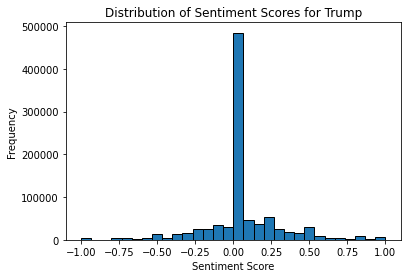

In [123]:
plt.hist(df_parquet_results_trump['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Trump')

# Show plot
plt.savefig('TrumpSentDist.png')

## Biden

In [124]:
# Examine Biden Sentiment distribution
df_parquet_results_biden['sentiment'].value_counts()

 0.000000    258794
 0.500000     12207
 0.800000      8162
 0.250000      6510
 0.200000      5782
              ...  
 0.051190         1
 0.292361         1
-0.042593         1
 0.173295         1
 0.201852         1
Name: sentiment, Length: 12118, dtype: int64

In [125]:
# look at sample of tweets for each outcome
df_parquet_results_biden[df_parquet_results_biden['sentiment'] < 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
9,"""@ossoff @common 3 Trillion Stimulus will be p...",tweet,<NA>,Biden,-0.300000
20,@SteveGuest So is #TonyBobulinski lying when h...,tweet,2020-10-09 19:24:36,Biden,-0.400000
31,"""The war in #Yemen may not last long into a #B...",tweet,<NA>,Biden,-0.025000
39,"""@MSNBC Total crap and #fakenews. The laptop ...",tweet,2020-10-20 19:52:13,Biden,-0.100000
50,Over #250k dead Americans endorse #joebiden fr...,tweet,"""Dallas",Biden,-0.031818


In [126]:
df_parquet_results_biden[df_parquet_results_biden['sentiment'] == 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
0,#Cubanos por #Biden sacan las uñas para defend...,tweet,"""Miami",Biden,0.0
1,"""#Biden promete firmar una orden ejecutiva par...",tweet,<NA>,Biden,0.0
2,"""@Fxhedgers 3 Trillion Stimulus will be passed...",tweet,<NA>,Biden,0.0
3,America’s next president = Democratic af. #Kam...,tweet,2020-07-30 14:42:29,Biden,0.0
4,"""Here's the next thing Joe Biden says he will ...",tweet,<NA>,Biden,0.0


In [127]:
df_parquet_results_biden[df_parquet_results_biden['sentiment'] > 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
8,Is it true? #Biden https://t.co/ly76Q5NVgm,tweet,<NA>,Biden,0.350000
15,You’re not black if you don’t vote Democrat -B...,tweet,,Biden,0.083333
21,Michigan Democratic Rep. Dingell: 'So many' au...,tweet,,Biden,0.500000
38,"""Vote #Biden if you like to pay more taxes. If...",tweet,<NA>,Biden,0.500000
48,Rounding the curve so much we’re going in circ...,tweet,31.0,Biden,0.200000


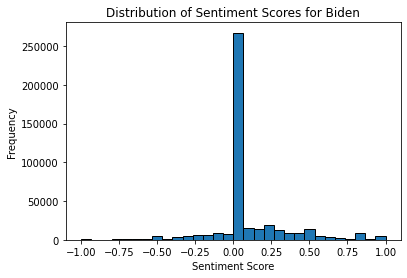

In [128]:
plt.hist(df_parquet_results_biden['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Biden')

# Show plot
plt.savefig('BidenSentDist.png')

## Preliminary Location Maps of Social Media Activity

In [ ]:
# Color Sentiment on Scale from Blue to Red going dark to light as it approaches neutral

# Overlappint popular cities
trump_cities = []
biden_cities = []

# Plot sentiment for cities



# Data Bias

## Prepare Dataset for Bias Analysis

In [3]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

from pyathena import connect

s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
database_name = "dbpoliticpulsecomment"
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

from textblob import TextBlob

def analyze_tweet_sentiment(tweet_text):
    analysis = TextBlob(tweet_text)
    # Return sentiment polarity (ranging from -1 to 1)
    return analysis.sentiment.polarity


# **********************DELETE PORTION ON THE TOP WHEN IT'S FINAL*************************



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [4]:
table_comment = "comment"

statement = """SELECT comment_body, source, candidatepoll FROM {}.{}
WHERE candidatepoll is not Null
    """.format(
    database_name, table_comment
)
df_combined = pd.read_sql(statement, conn)
df_combined = df_combined.drop_duplicates()
df_combined.info()

/tmp/ipykernel_7220/824970508.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_combined = pd.read_sql(statement, conn)


<class 'pandas.core.frame.DataFrame'>
Index: 1361968 entries, 0 to 1424243
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   comment_body   1361968 non-null  object
 1   source         1361968 non-null  object
 2   candidatepoll  1361968 non-null  object
dtypes: object(3)
memory usage: 41.6+ MB


In [5]:
# Run sentiment analysis textblob for all candidate
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_comment with a column 'text' containing tweet text
    df_comment_all = df_combined[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    df_comment_all['sentiment_score'] = df_combined['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_combined['sentiment'] = df_comment_all['sentiment_score']


/tmp/ipykernel_7220/1266410417.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comment_all['sentiment_score'] = df_combined['comment_body'].apply(analyze_tweet_sentiment)


<class 'pandas.core.frame.DataFrame'>
Index: 1361968 entries, 0 to 1424243
Data columns (total 5 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   comment_body        1361968 non-null  object 
 1   source              1361968 non-null  object 
 2   candidatepoll       1361968 non-null  object 
 3   sentiment           1361968 non-null  float64
 4   sentiment_category  1361968 non-null  object 
dtypes: float64(1), object(4)
memory usage: 62.3+ MB


<Axes: xlabel='sentiment_category', ylabel='count'>

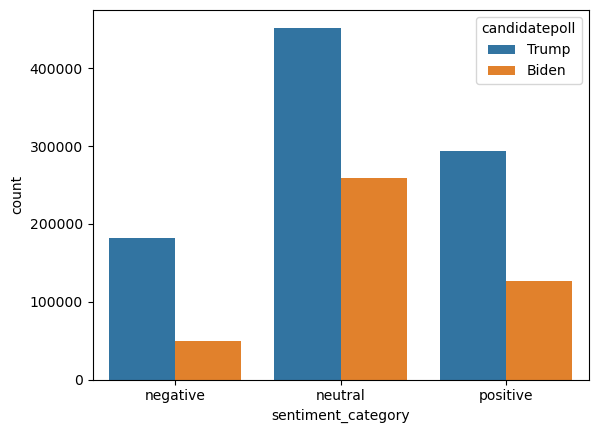

In [37]:
df_combined['sentiment_category'] = df_combined['sentiment'].apply(lambda x: 'negative' if x < 0 else ('neutral' if x == 0 else 'positive'))
df_combined.info()
sns.countplot(data=df_combined, x="sentiment_category", hue="candidatepoll")

In [ ]:
#Create folder
!mkdir -p ./data-clarify/

In [22]:
# chatgpt
# list folder
import os

# Get the current working directory
current_directory = "/home/sagemaker-user/ADS508_GroupProject"
spec_dir = "/home/sagemaker-user/ADS508_GroupProject/data-clarify"

# List the contents of the directory
for item in os.listdir(spec_dir):
    full_path = os.path.join(spec_dir, item)
    if os.path.isdir(full_path):
        print(f"Directory: {item}")
    else:
        print(f"File: {item}")

File: tweet_nyt_combined.csv
File: combine_balance.csv
File: combine_balance.jsonl


In [20]:
# All Data
path = "./data-clarify/tweet_nyt_combined.csv"
df_combined.to_csv(path, index=False, header=True)

<Axes: xlabel='sentiment_category', ylabel='count'>

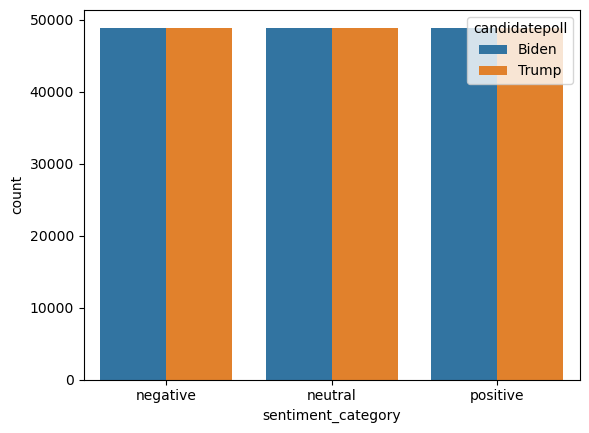

In [8]:
# Balance the Dataset by candidate and Sentiment score
import matplotlib.pyplot as plt
import seaborn as sns

df_grouped_by = df_combined.groupby(["candidatepoll", "sentiment_category"])[["candidatepoll", "sentiment_category"]]
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))
df_balanced.shape

sns.countplot(data=df_balanced, x="sentiment_category", hue="candidatepoll")

In [11]:
path_balance = "./data-clarify/combine_balance.csv"
df_balanced.to_csv(path_balance, index=False, header=True)

path_jsonlines = "./data-clarify/combine_balance.jsonl"
df_balanced.to_json(path_or_buf=path_jsonlines, orient="records", lines=True)

### Upload Combined and Balance Data to S3

In [12]:
# Create folder for specific timestamp
import time

timestamp = int(time.time())

bias_data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path)
bias_data_s3_uri

's3://sagemaker-us-west-2-471112815505/ADS508_project/bias-detection-1710780266/tweet_nyt_combined.csv'

In [13]:
!aws s3 ls $bias_data_s3_uri

2024-03-18 16:44:27  213533426 tweet_nyt_combined.csv


In [14]:
balanced_bias_data_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_balance
)
balanced_bias_data_s3_uri

's3://sagemaker-us-west-2-471112815505/ADS508_project/bias-detection-1710780266/combine_balance.csv'

In [15]:
!aws s3 ls $balanced_bias_data_s3_uri

2024-03-18 16:44:30    4305873 combine_balance.csv


In [16]:
balanced_bias_data_jsonlines_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_jsonlines
)
balanced_bias_data_jsonlines_s3_uri

's3://sagemaker-us-west-2-471112815505/ADS508_project/bias-detection-1710780266/combine_balance.jsonl'

In [17]:
!aws s3 ls $balanced_bias_data_jsonlines_s3_uri

2024-03-18 16:44:32   16929780 combine_balance.jsonl


## Run Data Bias Analysis

In [18]:
#!pip install --force-reinstall -q smclarify

from smclarify.bias import report
from typing import Dict
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
!aws s3 cp $bias_data_s3_uri ./data-clarify/

download: s3://sagemaker-us-west-2-471112815505/ADS508_project/bias-detection-1710780266/tweet_nyt_combined.csv to data-clarify/tweet_nyt_combined.csv


In [25]:
!aws s3 cp $balanced_bias_data_s3_uri ./data-clarify/

download: s3://sagemaker-us-west-2-471112815505/ADS508_project/bias-detection-1710780266/combine_balance.csv to data-clarify/combine_balance.csv


### Calculate Bias Metrics for all Data
#### might not needed from ===>

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_combined["sentiment_category"],
    positive_label_values=[5]
)

In [41]:
report.bias_report(
    df=df_combined, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

[{'value_or_threshold': 'Trump',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': -0.36115385970889186},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': 0.0},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': 0.0},
   {'name': 'KL',
    'description': 'Kullback-Liebler Divergence (KL)',
    'value': 0.0},
   {'name': 'KS',
    'description': 'Kolmogorov-Smirnov Distance (KS)',
    'value': 0.0},
   {'name': 'LP', 'description': 'L-p Norm (LP)', 'value': 0.0},
   {'name': 'TVD',
    'description': 'Total Variation Distance (TVD)',
    'value': 0.0}]},
 {'value_or_threshold': 'Biden',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.36115385970889186},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': 0.0},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (

### Calculate Bias Metrics for Balanced Data

In [38]:
from smclarify.bias import report

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_balanced["sentiment_category"], 
    positive_label_values=[5]
)

In [39]:
report.bias_report(
    df=df_balanced, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

/opt/conda/lib/python3.10/site-packages/smclarify/bias/metrics/common.py:227: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(positive_label_values[0], type(series[0])):
/opt/conda/lib/python3.10/site-packages/smclarify/bias/metrics/common.py:232: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(series[0], bool) and isinstance(positive_label_values, str) and positive_label_values[0].isalpha():
/opt/conda/lib/python3.10/site-packages/smclarify/bias/metrics/common.py:238: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

[{'value_or_threshold': 'Biden',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.0},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': 0.0},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': 0.0},
   {'name': 'KL',
    'description': 'Kullback-Liebler Divergence (KL)',
    'value': 0.0},
   {'name': 'KS',
    'description': 'Kolmogorov-Smirnov Distance (KS)',
    'value': 0.0},
   {'name': 'LP', 'description': 'L-p Norm (LP)', 'value': 0.0},
   {'name': 'TVD',
    'description': 'Total Variation Distance (TVD)',
    'value': 0.0}]},
 {'value_or_threshold': 'Trump',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.0},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': 0.0},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': 0.0},
   {'nam

#### <=== TO MIGHT NOT NEEDED

### Run Data Bias Analysis (Pre-training)

In [42]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.c5.xlarge", 
    sagemaker_session=sess
)

#### Pre-Training Bias

In [51]:
bias_report_output_path = "s3://{}/ADS508_project/clarify".format(bucket)

bias_data_config = clarify.DataConfig(
    s3_data_input_path=bias_data_s3_uri,
    s3_output_path=bias_report_output_path,
    label="sentiment_category",
    headers=df_combined.columns.to_list(),
    dataset_type="text/csv",
)


In [52]:
# Trump
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Trump"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name



INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['comment_body', 'source', 'candidatepoll', 'sentiment', 'sentiment_category'], 'label': 'sentiment_category', 'label_values_or_threshold': [5], 'facet': [{'name_or_index': 'candidatepoll', 'value_or_threshold': ['Trump']}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': ['CI', 'DPL', 'KL', 'JS', 'LP', 'TVD', 'KS']}}}
INFO:sagemaker:Creating processing-job with name Clarify-Pretraining-Bias-2024-03-18-17-44-12-270


'Clarify-Pretraining-Bias-2024-03-18-17-44-12-270'

In [53]:
# Biden
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Biden"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name


INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['comment_body', 'source', 'candidatepoll', 'sentiment', 'sentiment_category'], 'label': 'sentiment_category', 'label_values_or_threshold': [5], 'facet': [{'name_or_index': 'candidatepoll', 'value_or_threshold': ['Biden']}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': ['CI', 'DPL', 'KL', 'JS', 'LP', 'TVD', 'KS']}}}
INFO:sagemaker:Creating processing-job with name Clarify-Pretraining-Bias-2024-03-18-17-44-12-756


'Clarify-Pretraining-Bias-2024-03-18-17-44-12-756'

#### Download report

In [54]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, run_pre_training_bias_processing_job_name, region
        )
    )
)

/tmp/ipykernel_7220/3186442838.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/tmp/ipykernel_7220/3186442838.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/tmp/ipykernel_7220/3186442838.py:20: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [55]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()

print(processing_job_description)

{'ProcessingInputs': [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-471112815505/ADS508_project/bias-detection-1710780266/tweet_nyt_combined.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-471112815505/ADS508_project/clarify/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}], 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'analysis_result', 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-471112815505/ADS508_project/clarify', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}, 'AppManaged': False}]}, 'ProcessingJobName': 'Clarify-Pretraining-Bias-

In [56]:
!aws s3 ls $bias_report_output_path/

2024-03-18 17:44:13        415 analysis_config.json


In [57]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/

download: s3://sagemaker-us-west-2-471112815505/ADS508_project/clarify/analysis_config.json to generated_bias_report/analysis_config.json


In [58]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/report.html">Bias Report</a></b>'))

/tmp/ipykernel_7220/2239962916.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
path = "./data-clarify/amazon_reviews_us_giftcards_software_videogames.csv"
df.to_csv(path, index=False, header=True)